# Fruit Classification Model

In [4]:
import os
import pickle
import random

from keras import backend as K
from keras import metrics
from keras.applications.vgg16 import VGG16
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Activation,Dense,Dropout,Flatten,BatchNormalization
from keras.models import load_model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import wget

In [2]:
#Keras reproducibility (without GPU)

# Set seeds
np.random.seed(42)
random.seed(12345)

# Force TensorFlow to use single thread.
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Data

- 300 images of apples, oranges and pears each scrapped using google_images_download using the keywords 'apples fruit', 'oranges fruit' and 'pear fruit'

- Checking your chrome version https://www.whatismybrowser.com/detect/what-version-of-chrome-do-i-have and download the correct chromedriver here: http://chromedriver.chromium.org/downloads

- Images cleaned (RGB only) and processed by resizing to 244 X 244 (centered)

- Images stored as pickle files (300 X 244 X 244 X 3 np arrays) and uploaded to google drive (publicly accessible).

- Load file into jupyter notebook from google drive using wget.

In [6]:
# Use wget to download pickle files from google

#setup data directory in current directory if not present
if not os.path.isdir('./data'):
    os.mkdir('./data')

#apples
path  = './data/x_apples.pkl'
if not os.path.exists(path):
    print('start download x_apples.pkl...', end='')
    wget.download('https://drive.google.com/uc?export=download&id=1rFDkhfChmKU-9X_UcqdpFwTLFs6mm-LR', out=path, bar=None)
    print('done')
    
#oranges
path  = './data/x_oranges.pkl'
if not os.path.exists(path):
    print('start download x_oranges.pkl...', end='')
    wget.download('https://drive.google.com/uc?export=download&id=1bLulvDKAMtPgALrcdH3HfzBwLOFItR4s', out=path, bar=None)
    print('done')
    
#pears
path  = './data/x_pears.pkl'
if not os.path.exists(path):
    print('start download x_pears.pkl...', end='')
    wget.download('https://drive.google.com/uc?export=download&id=1-nerhTEFRPABATA1gP3EJEDsok8tzdJl', out=path, bar=None)
    print('done')
    
# Unpickle to get np array for each data set 
x_apple = pickle.load(open('./data/x_apples.pkl', 'rb'))
x_orange = pickle.load(open('./data/x_oranges.pkl', 'rb'))
x_pear = pickle.load(open('./data/x_pears.pkl', 'rb'))

start download x_apples.pkl...done
start download x_oranges.pkl...done
start download x_pears.pkl...done


### 2.3 Train model

- Transfer learning using pre-trained VGG-16 model (only training the FC layers)
- Set up as a multiclass classification problem with 3 classes: Apples, Oranges, Pears
- Trained model saved as model.h5 file, evaluated by validation loss and validation accuracy

In [7]:
# Put together a dataset with labels
num_images = 25

x = np.concatenate([x_apple,x_orange,x_pear],axis=0)
y = [0]*(num_images-1) + [1]*num_images + [2]*num_images

#Train-test split and format labels for keras multiclass classification
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)
y_train = to_categorical(y_train,3,'float32')
y_val = to_categorical(y_val,3,'float32')

#Define data generator for data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True)

In [8]:
# Load pretrained VGG-16 model without FC layer
model = VGG16(weights = "imagenet", include_top=False, input_shape = (244, 244, 3))

# Freeze all pre-trained layers
for layer in model.layers:
    layer.trainable = False

#Define FC layers 
Initializer = 'he_normal'
activation = Activation('relu')
Regularizer = l2
regparam = 5e-3    

model2 = Sequential()
model2.add(model)

model2.add(Flatten())

model2.add(Dense(64,kernel_initializer=Initializer,kernel_regularizer=Regularizer(regparam)))
model2.add(BatchNormalization(momentum=0.9))
model2.add(activation)
model2.add(Dropout(0.7,seed=123))

model2.add(Dense(3,kernel_initializer=Initializer))
model2.add(Activation('softmax'))

# Set optimizers and compile model
adam = Adam(beta_1=0.9, beta_2=0.999, decay=0)
model2.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics = ['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
__________

In [9]:
def lr_sch(epoch):
    #Learning rate schedule for stochastic gradient descent with restarts (cosine annealing)

    min_lr = 1e-5
    max_lr = 1e-3
    # number of epochs to restart
    restart = 5 

    lrate = min_lr + 0.5*(max_lr - min_lr) * (1+np.cos(((epoch - (epoch//restart * restart))/ restart) * np.pi))      

    return lrate

lrsch = LearningRateScheduler(lr_sch)

#Save best model file at checkpoint 
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', period=1)

#model_fit

batch_size = 8
modelfit = model2.fit_generator(datagen.flow(x_train, y_train, batch_size),
        steps_per_epoch = x_train.shape[0] / batch_size, 
        epochs=5,
        verbose=1,
        validation_data = (x_val,y_val),
        callbacks=[lrsch,checkpoint] 
        )

Epoch 1/5
7/6 [================================] - 91s 13s/step - loss: 1.8307 - acc: 0.5221 - val_loss: 0.8683 - val_acc: 0.8696
Epoch 2/5
7/6 [================================] - 90s 13s/step - loss: 1.0721 - acc: 0.7209 - val_loss: 0.6262 - val_acc: 1.0000
Epoch 3/5
7/6 [================================] - 95s 14s/step - loss: 1.1783 - acc: 0.7672 - val_loss: 0.6319 - val_acc: 1.0000
Epoch 4/5
7/6 [================================] - 111s 16s/step - loss: 0.8454 - acc: 0.8474 - val_loss: 0.6328 - val_acc: 1.0000
Epoch 5/5
7/6 [================================] - 93s 13s/step - loss: 0.8228 - acc: 0.8554 - val_loss: 0.6627 - val_acc: 1.0000


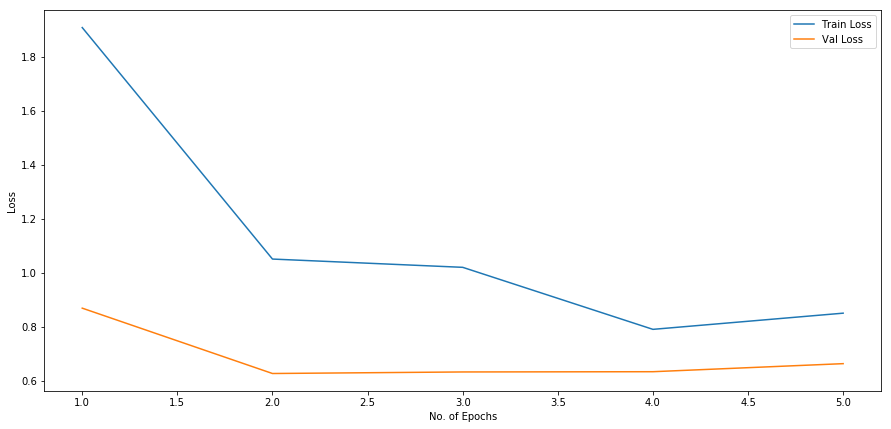

In [10]:
#Learning Curves

#Get data from modelfit and put them into a summary dataframe
trainloss = pd.DataFrame(modelfit.history['loss'])
trainacc = pd.DataFrame(modelfit.history['acc'])
valloss = pd.DataFrame(modelfit.history['val_loss'])
valacc = pd.DataFrame(modelfit.history['val_acc'])

summary = pd.concat([trainloss,trainacc,valloss,valacc],axis=1)
summary.columns = ["train loss","train acc","val loss","val acc"]

#Plot learning curves
f, ax = plt.subplots(figsize=(15, 7))
plt.plot(summary.index+1,summary['train loss'],label='Train Loss')
plt.plot(summary.index+1,summary['val loss'],label='Val Loss')
x_axis = plt.xlabel('No. of Epochs')
y_axis = plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
#Evaluate model saved in h5 file
model_saved = load_model('model.h5')

evaluate = model_saved.evaluate(x_val,y_val)
print('Validation Loss: {0}'.format(evaluate[0]))
print('Validation Accuracy: {0}'.format(evaluate[1]))

23/23 [==============================] - 27s 1s/step
Validation Loss: 0.6261733174324036
Validation Accuracy: 1.0
